In [1]:
import pandas as pd
import numpy as np
from statsbombpy import sb
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from scipy.ndimage import gaussian_filter
import warnings


In [2]:
warnings.filterwarnings('ignore')

In [3]:
free_comps = sb.competitions()

In [4]:
free_comps.columns

Index(['competition_id', 'season_id', 'country_name', 'competition_name',
       'competition_gender', 'competition_youth', 'competition_international',
       'season_name', 'match_updated', 'match_updated_360',
       'match_available_360', 'match_available'],
      dtype='object')

In [5]:
mls_matches = sb.matches(competition_id = 44, season_id = 107)

In [6]:
mls_matches.head(2)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3877060,2023-08-27,02:39:00.000,United States of America - Major League Soccer,2023,New York Red Bulls,Inter Miami,0,2,available,...,2023-11-22T12:46:54.939710,28,Regular Season,Red Bull Arena (New Jersey),Allen Chapman,Troy Lesesne,Gerardo Daniel Martino,1.1.0,2,2
1,3877090,2023-09-04,05:09:00.000,United States of America - Major League Soccer,2023,LAFC,Inter Miami,1,3,available,...,2023-11-19T14:27:32.827119,30,Regular Season,BMO Stadium,Ted Unkel,Steven Cherundolo,Gerardo Daniel Martino,1.1.0,2,2


In [7]:
mls_matches['home_team'].values

array(['New York Red Bulls', 'LAFC', 'Charlotte', 'Inter Miami',
       'Inter Miami', 'Inter Miami'], dtype=object)

In [8]:
mls_matches[mls_matches['home_team'] == 'LAFC']

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
1,3877090,2023-09-04,05:09:00.000,United States of America - Major League Soccer,2023,LAFC,Inter Miami,1,3,available,...,2023-11-19T14:27:32.827119,30,Regular Season,BMO Stadium,Ted Unkel,Steven Cherundolo,Gerardo Daniel Martino,1.1.0,2,2


In [9]:
mls_dallas = mls_matches

In [10]:
events_df = sb.events(match_id = 3877090)

In [11]:
for k in events_df.columns:
    print(k)

50_50
bad_behaviour_card
ball_receipt_outcome
ball_recovery_recovery_failure
block_offensive
carry_end_location
clearance_aerial_won
clearance_body_part
clearance_head
clearance_left_foot
clearance_right_foot
counterpress
dribble_no_touch
dribble_nutmeg
dribble_outcome
dribble_overrun
duel_outcome
duel_type
duration
foul_committed_advantage
foul_committed_card
foul_won_advantage
foul_won_defensive
goalkeeper_body_part
goalkeeper_end_location
goalkeeper_outcome
goalkeeper_position
goalkeeper_technique
goalkeeper_type
id
index
injury_stoppage_in_chain
interception_outcome
location
match_id
minute
off_camera
out
pass_aerial_won
pass_angle
pass_assisted_shot_id
pass_body_part
pass_cross
pass_cut_back
pass_end_location
pass_goal_assist
pass_height
pass_inswinging
pass_length
pass_miscommunication
pass_no_touch
pass_outcome
pass_recipient
pass_recipient_id
pass_shot_assist
pass_switch
pass_technique
pass_through_ball
pass_type
period
play_pattern
player
player_id
position
possession
possessi

In [12]:
events_df.play_pattern.value_counts()

play_pattern
Regular Play      1540
From Throw In      659
From Free Kick     582
From Goal Kick     227
From Keeper        147
From Kick Off      106
From Corner         96
From Counter        36
Other                2
Name: count, dtype: int64

In [13]:
df = events_df[['team' ,'minute','player', 'location', 'carry_end_location','pass_end_location','play_pattern','pass_type', 'pass_shot_assist','pass_goal_assist','under_pressure','pass_through_ball','pass_cross','pass_cut_back','shot_statsbomb_xg']]

In [14]:
df_shot = events_df[['team' ,'minute','player', 'location','shot_end_location', 'shot_one_on_one','shot_outcome']]

In [15]:
df.head()

,team,minute,player,location,carry_end_location,pass_end_location,play_pattern,pass_type,pass_shot_assist,pass_goal_assist,under_pressure,pass_through_ball,pass_cross,pass_cut_back,shot_statsbomb_xg
0,LAFC,0,NaN,NaN,NaN,NaN,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Inter Miami,0,NaN,NaN,NaN,NaN,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LAFC,0,NaN,NaN,NaN,NaN,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Inter Miami,0,NaN,NaN,NaN,NaN,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LAFC,45,NaN,NaN,NaN,NaN,From Free Kick,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_cross = df[(df['team'] == 'LAFC') & (df['pass_cross'] == True)]

In [17]:
df_cross['xstart'] = df_cross['location'].str[0]
df_cross['ystart'] = df_cross['location'].str[1]
df_cross['xend'] = df_cross['pass_end_location'].str[0]
df_cross['yend'] = df_cross['pass_end_location'].str[1]

In [18]:
df_cross.head()

,team,minute,player,location,carry_end_location,pass_end_location,play_pattern,pass_type,pass_shot_assist,pass_goal_assist,under_pressure,pass_through_ball,pass_cross,pass_cut_back,shot_statsbomb_xg,xstart,ystart,xend,yend
66,LAFC,4,Denis Bouanga,"[111.3, 12.4]",NaN,"[112.7, 40.3]",Regular Play,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,111.3,12.4,112.7,40.3
69,LAFC,5,Carlos Alberto Vela Garrido,"[112.5, 73.9]",NaN,"[108.6, 27.1]",From Corner,Recovery,NaN,NaN,NaN,NaN,True,NaN,NaN,112.5,73.9,108.6,27.1
316,LAFC,27,Sergi Palencia Hurtado,"[98.0, 68.9]",NaN,"[109.5, 35.9]",Regular Play,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,98.0,68.9,109.5,35.9
324,LAFC,27,Giorgio Chiellini,"[89.2, 4.0]",NaN,"[111.9, 76.8]",Regular Play,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,89.2,4.0,111.9,76.8
528,LAFC,47,Denis Bouanga,"[109.6, 13.1]",NaN,"[111.9, 36.5]",Regular Play,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,109.6,13.1,111.9,36.5


In [19]:
df_cross['play_pattern'].value_counts()

play_pattern
Regular Play      6
From Free Kick    3
From Corner       1
From Goal Kick    1
From Counter      1
From Keeper       1
From Throw In     1
Name: count, dtype: int64

In [20]:
#Note: Statsbomb x coordinates = 0 to 120 (left to right), y coordinates = 80 to 0 (top to bottom)

pitch = Pitch(pitch_type='statsbomb')



### Plot for crosses, crosses that led to a shot (green), and cross under pressure (orange)

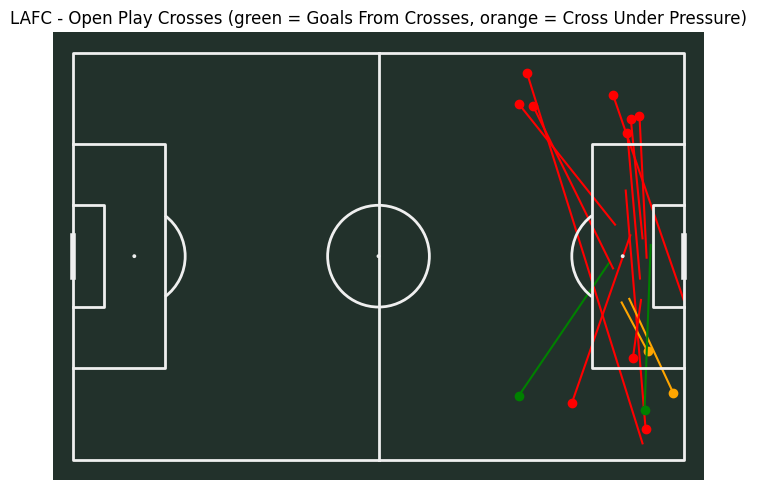

In [50]:
fig, ax = pitch.draw(figsize=(8,5))

for i in range(len(df_cross)):
    row = df_cross.iloc[i]
    if row['pass_shot_assist'] == True:
        color = 'green'
    elif row['under_pressure'] == True:
        color = 'orange'
    else:
        color = 'red'
    
    ax.plot([row['xstart'], row['xend']], [row['ystart'], row['yend']], color=color)
    ax.plot(row['xstart'], row['ystart'], 'o', color=color)

ax.set_title('LAFC - Open Play Crosses (green = Goals From Crosses, orange = Cross Under Pressure)')
plt.show()

In [22]:
df_shot['xstart'] = df_shot['location'].str[0]
df_shot['ystart'] = df_shot['location'].str[1]
df_shot['xend'] = df_shot['shot_end_location'].str[0]
df_shot['yend'] = df_shot['shot_end_location'].str[1]

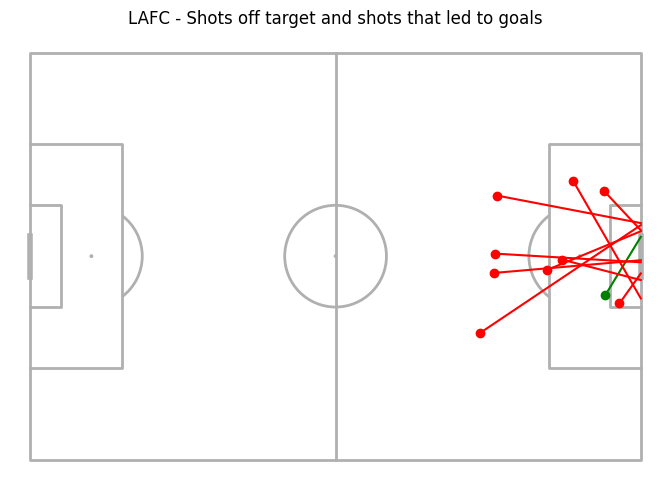

In [23]:
fig, ax = pitch.draw(figsize=(8,5))

#Shots on goal
shots = df_shot[(df_shot['team'] == 'LAFC') & (df_shot['shot_outcome'] == 'Goal')]
ax.plot((shots.xstart, shots.xend),(shots.ystart, shots.yend),color = 'green')
ax.plot(shots.xstart, shots.ystart, 'o', color = 'green')

#Shots off target
shots_ot = df_shot[(df_shot['team'] == 'LAFC') & (df_shot['shot_outcome'] == 'Off T')]
ax.plot((shots_ot.xstart, shots_ot.xend),(shots_ot.ystart, shots_ot.yend),color = 'red')
ax.plot(shots_ot.xstart, shots_ot.ystart, 'o', color = 'red')

ax.set_title("LAFC - Shots off target and shots that led to goals")
plt.show()


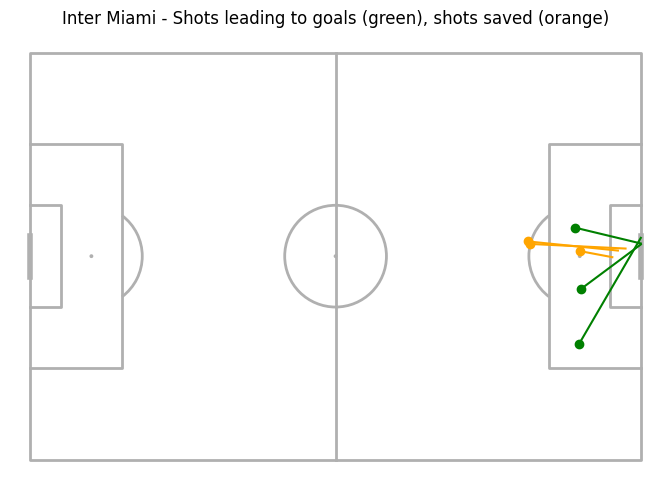

In [24]:
fig, ax = pitch.draw(figsize=(8,5))

#Shots on goal
shots = df_shot[(df_shot['team'] == 'Inter Miami') & (df_shot['shot_outcome'] == 'Goal')]
ax.plot((shots.xstart, shots.xend),(shots.ystart, shots.yend),color = 'green')
ax.plot(shots.xstart, shots.ystart, 'o', color = 'green')

#Shots off target
shots_ot = df_shot[(df_shot['team'] == 'Inter Miami') & (df_shot['shot_outcome'] == 'Saved')]
ax.plot((shots_ot.xstart, shots_ot.xend),(shots_ot.ystart, shots_ot.yend),color = 'orange')
ax.plot(shots_ot.xstart, shots_ot.ystart, 'o', color = 'orange')

ax.set_title("Inter Miami - Shots leading to goals (green), shots saved (orange)")
plt.show()


### Heat map of under pressure events

In [25]:
pressure_events = events_df[['team' ,'minute','player', 'location','shot_end_location', 'shot_one_on_one','shot_outcome','pass_outcome', 'under_pressure']]

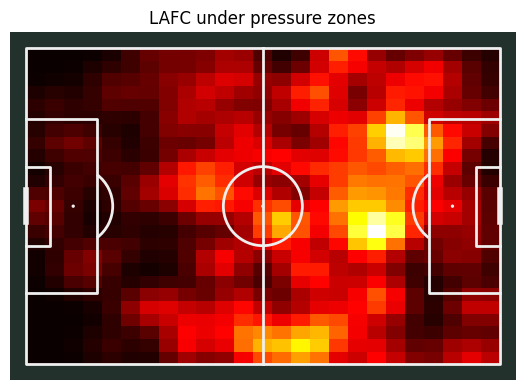

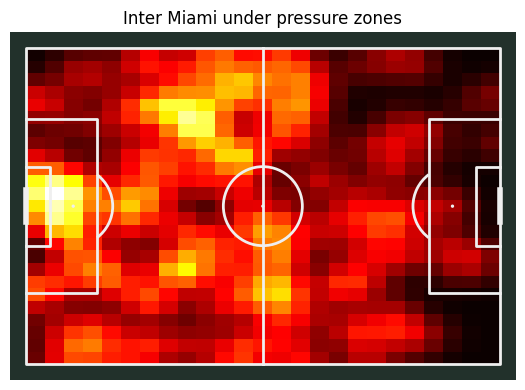

In [26]:
for Team in events_df['team'].unique():
    pressure_events = events_df[(events_df['team'] == Team) & (events_df['under_pressure'] == True)]
    pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#efefef', line_zorder=3)
    fig, ax = pitch.draw(figsize=(8, 4))
    bin_stat = pitch.bin_statistic(pressure_events['location'].str[0], pressure_events['location'].str[1], statistic='count', bins = (25,25))
    bin_stat['statistic'] = gaussian_filter(bin_stat['statistic'],1)
    pcm = pitch.heatmap(bin_stat, ax = ax, cmap = 'hot')
    ax.set_title(f'{Team} under pressure zones')
plt.show()

In [27]:
df.columns

Index(['team', 'minute', 'player', 'location', 'carry_end_location',
       'pass_end_location', 'play_pattern', 'pass_type', 'pass_shot_assist',
       'pass_goal_assist', 'under_pressure', 'pass_through_ball', 'pass_cross',
       'pass_cut_back', 'shot_statsbomb_xg'],
      dtype='object')

In [28]:
df.carry_end_location.describe()

count              709
unique             709
top       [37.7, 39.8]
freq                 1
Name: carry_end_location, dtype: object

In [29]:
df.play_pattern.value_counts()

play_pattern
Regular Play      1540
From Throw In      659
From Free Kick     582
From Goal Kick     227
From Keeper        147
From Kick Off      106
From Corner         96
From Counter        36
Other                2
Name: count, dtype: int64

In [30]:
events_df[['team' ,'minute','player', 'location','shot_end_location', 'shot_one_on_one','shot_outcome']]

,team,minute,player,location,shot_end_location,shot_one_on_one,shot_outcome
0,LAFC,0,NaN,NaN,NaN,NaN,NaN
1,Inter Miami,0,NaN,NaN,NaN,NaN,NaN
2,LAFC,0,NaN,NaN,NaN,NaN,NaN
3,Inter Miami,0,NaN,NaN,NaN,NaN,NaN
4,LAFC,45,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3390,Inter Miami,55,NaN,"[7.8, 37.3]",NaN,NaN,NaN
3391,Inter Miami,55,Facundo Farías,"[56.1, 1.0]",NaN,NaN,NaN
3392,LAFC,82,Aaron Long,"[56.7, 46.5]",NaN,NaN,NaN
3393,Inter Miami,85,Diego Alexander Gómez Amarilla,NaN,NaN,NaN,NaN


In [31]:
events_df.columns

Index(['50_50', 'bad_behaviour_card', 'ball_receipt_outcome',
       'ball_recovery_recovery_failure', 'block_offensive',
       'carry_end_location', 'clearance_aerial_won', 'clearance_body_part',
       'clearance_head', 'clearance_left_foot', 'clearance_right_foot',
       'counterpress', 'dribble_no_touch', 'dribble_nutmeg', 'dribble_outcome',
       'dribble_overrun', 'duel_outcome', 'duel_type', 'duration',
       'foul_committed_advantage', 'foul_committed_card', 'foul_won_advantage',
       'foul_won_defensive', 'goalkeeper_body_part', 'goalkeeper_end_location',
       'goalkeeper_outcome', 'goalkeeper_position', 'goalkeeper_technique',
       'goalkeeper_type', 'id', 'index', 'injury_stoppage_in_chain',
       'interception_outcome', 'location', 'match_id', 'minute', 'off_camera',
       'out', 'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id',
       'pass_body_part', 'pass_cross', 'pass_cut_back', 'pass_end_location',
       'pass_goal_assist', 'pass_height', 'pass_in

In [32]:
df_carries = events_df[['team' ,'minute','play_pattern', 'player', 'location','carry_end_location']]

In [33]:
df_carries['carry_end_x'] = df['carry_end_location'].str[0]
df_carries['carry_end_y'] = df['carry_end_location'].str[1]
df_carries['xstart'] = df['location'].str[0]
df_carries['ystart'] = df['location'].str[1]

In [34]:
df_carries.head()

,team,minute,play_pattern,player,location,carry_end_location,carry_end_x,carry_end_y,xstart,ystart
0,LAFC,0,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Inter Miami,0,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LAFC,0,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Inter Miami,0,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LAFC,45,From Free Kick,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#Change the data type of the carries x and carrues y columns for comparison later on

text_cols = ['team', 'play_pattern', 'location', 'carry_end_location']

for col in df_carries.columns:
    if col not in text_cols:
        df_carries[col] = pd.to_numeric(df_carries[col], errors= 'coerce')

In [36]:
df_carries.dtypes

team                   object
minute                  int64
play_pattern           object
player                float64
location               object
carry_end_location     object
carry_end_x           float64
carry_end_y           float64
xstart                float64
ystart                float64
dtype: object

### Divide the pitch into 3 areas: defensive middle and attacking third lenth wise. So final third entries will have a x coordinate > 80.0 as per simple math

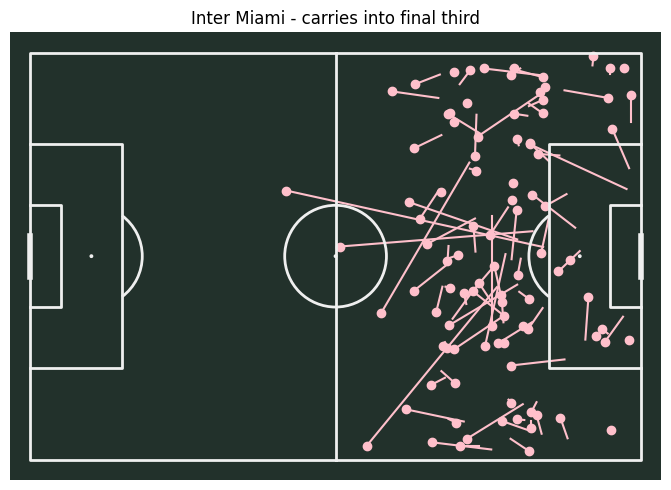

In [38]:
fig, ax = pitch.draw(figsize=(8,5))


#Inter Miami carries into final third
carries_f3rd = df_carries[(df_carries['team'] == 'Inter Miami') & (df_carries['carry_end_x'] > 80)]
ax.plot((carries_f3rd.xstart, carries_f3rd.carry_end_x),(carries_f3rd.ystart, carries_f3rd.carry_end_y),color = 'pink')
ax.plot(carries_f3rd.xstart, carries_f3rd.ystart, 'o', color = 'pink')


ax.set_title("Inter Miami - carries into final third")

plt.show()


Text(0.5, 1.0, 'LAFC - carries into final third')

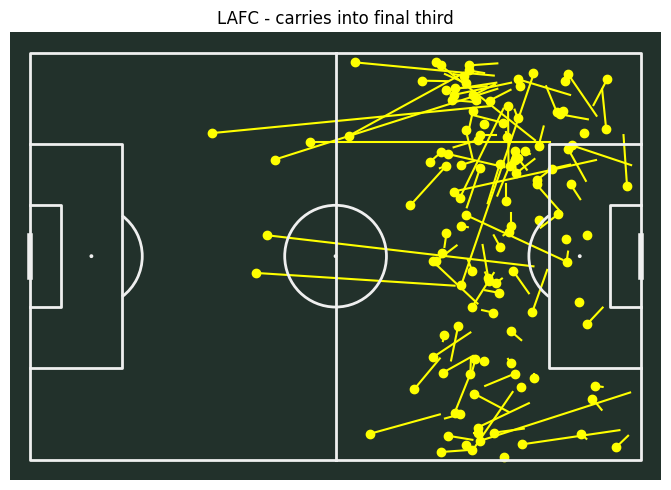

In [39]:
#LAFC carries into final third
fix, ax = pitch.draw(figsize=(8,5))

carries_f3rd = df_carries[(df_carries['team'] == 'LAFC') & (df_carries['carry_end_x'] > 80)]
ax.plot((carries_f3rd.xstart, carries_f3rd.carry_end_x),(carries_f3rd.ystart, carries_f3rd.carry_end_y),color = 'yellow')
ax.plot(carries_f3rd.xstart, carries_f3rd.ystart, 'o', color = 'yellow')


ax.set_title("LAFC - carries into final third")

### Finding passes from half spaces

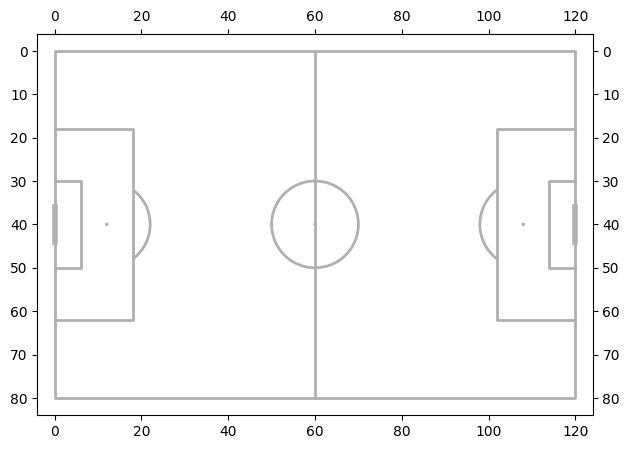

In [40]:
pitch_axes = Pitch(pitch_type= 'statsbomb',axis = True, label = True, tick = True)
fix, ax = pitch_axes.draw()

#### From the above axes and labels, the half spaces fall somewhere between (19, 30) and (50, 61) on the y-axis, 

In [41]:
df_passes = df[df['play_pattern'] == 'Regular Play']

In [42]:
#Retriving the start and end locations for passes

df_passes['xstart'] = df_passes['location'].str[0]
df_passes['ystart'] = df_passes['location'].str[1]
df_passes['pass_xend']= df_passes['pass_end_location'].str[0]
df_passes['pass_yend']= df_passes['pass_end_location'].str[1]

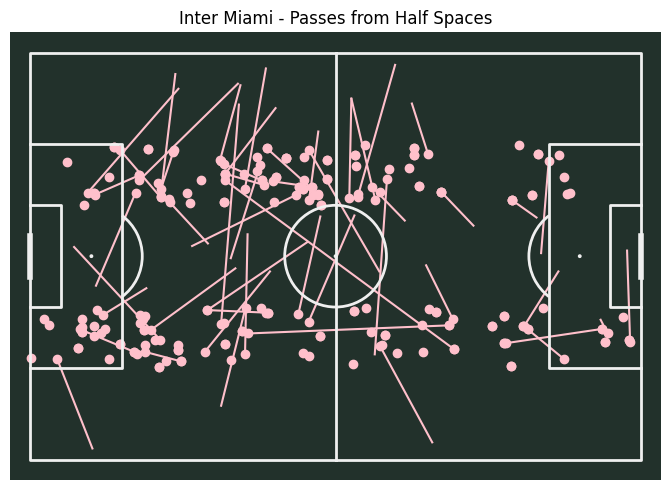

In [46]:
fig, ax = pitch.draw(figsize=(8,5))

# Passes from BOTH half spaces (left OR right)
passes_hs = df_passes[(df_passes['team'] == 'Inter Miami') & 
                     (((df_passes['ystart'] > 18) & (df_passes['ystart'] <= 30)) |
                      ((df_passes['ystart'] >= 50) & (df_passes['ystart'] <= 62)))]

ax.plot((passes_hs['xstart'], passes_hs['pass_xend']), 
        (passes_hs['ystart'], passes_hs['pass_yend']), 
        color='pink')
ax.plot(passes_hs['xstart'], passes_hs['ystart'], 'o', color='pink')

ax.set_title('Inter Miami - Passes from Half Spaces')
plt.show()

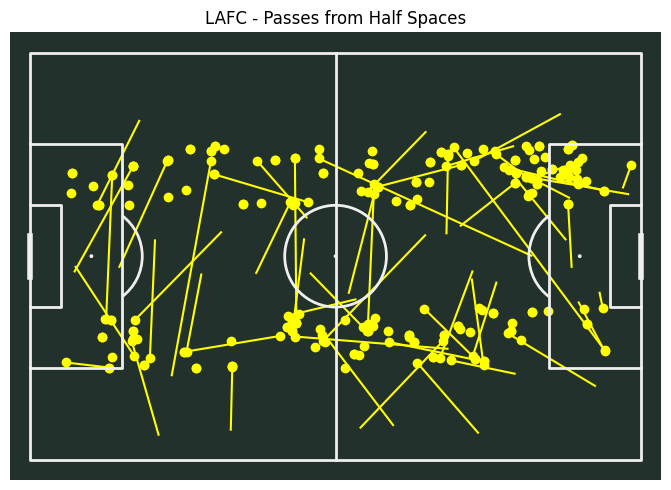

In [47]:
fig, ax = pitch.draw(figsize=(8,5))

# Passes from BOTH half spaces (left OR right)
passes_hs = df_passes[(df_passes['team'] == 'LAFC') & 
                     (((df_passes['ystart'] > 18) & (df_passes['ystart'] <= 30)) |
                      ((df_passes['ystart'] >= 50) & (df_passes['ystart'] <= 62)))]

ax.plot((passes_hs['xstart'], passes_hs['pass_xend']), 
        (passes_hs['ystart'], passes_hs['pass_yend']), 
        color='yellow')
ax.plot(passes_hs['xstart'], passes_hs['ystart'], 'o', color='yellow')

ax.set_title('LAFC - Passes from Half Spaces')
plt.show()

In [45]:
df.play_pattern.value_counts()

play_pattern
Regular Play      1540
From Throw In      659
From Free Kick     582
From Goal Kick     227
From Keeper        147
From Kick Off      106
From Corner         96
From Counter        36
Other                2
Name: count, dtype: int64